In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/pytorch-gnn-meta-attack
%ls

/content/drive/MyDrive/Colab Notebooks/pytorch-gnn-meta-attack
 data/             metattack.py                __pycache__/   results_on_citeseer.png   utils.py
 gcn.py           'pertubation search.ipynb'   README.md      results_on_cora.png
 metattack.ipynb   pre-attacked/               results/       test_metattack.py


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00


In [4]:
# make sure to clone https://github.com/ChandlerBang/pytorch-gnn-meta-attack.git

In [5]:
import torch
from utils import *
import argparse
from gcn import GCN
import numpy as np
from metattack import MetaApprox, Metattack
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from matplotlib import pyplot as plt
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn.models import GAT

In [6]:
import sys
import argparse

sys.argv = [
    'notebook',
    '--seed', '15',
    '--epochs', '100',
    '--lr', '0.01',
    '--hidden', '4',
    '--dataset', 'citeseer',
    '--ptb_rate', '0.1',
    '--model', 'Meta-Self'
]

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=15, help='Random seed.')
parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--hidden', type=int, default=4, help='Number of hidden units.')
parser.add_argument('--dataset', type=str, default='cora', choices=['cora', 'cora_ml', 'citeseer', 'polblogs'], help='dataset')
parser.add_argument('--ptb_rate', type=float, default=0.1, help='perturbation rate')
parser.add_argument('--model', type=str, default='A-Meta-Self', choices=['A-Meta-Self', 'Meta-Self'], help='model variant')

args = parser.parse_args()
print(args)

Namespace(seed=15, epochs=100, lr=0.01, hidden=4, dataset='citeseer', ptb_rate=0.1, model='Meta-Self')


In [22]:
args.model

'Meta-Self'

In [7]:

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu':
    torch.cuda.manual_seed(args.seed)

# === loading dataset
adj, features, labels = load_data(dataset=args.dataset)
nclass = max(labels) + 1

val_size = 0.1
test_size = 0.8
train_size = 1 - test_size - val_size

idx = np.arange(adj.shape[0])
idx_train, idx_val, idx_test = get_train_val_test(idx, train_size, val_size, test_size, stratify=labels)
idx_unlabeled = np.union1d(idx_val, idx_test)
perturbations = int(args.ptb_rate * (adj.sum()//2))

adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False)

# set up attack model
if 'Self' in args.model:
    lambda_ = 0
if 'Train' in args.model:
    lambda_ = 1
if 'Both' in args.model:
    lambda_ = 0.5

lambda_ = 0.5

if 'A' in args.model:
    model = MetaApprox(nfeat=features.shape[1], hidden_sizes=[args.hidden],
                       nnodes=adj.shape[0], nclass=nclass, dropout=0.5,
                       train_iters=100, attack_features=True, lambda_=lambda_, device=device)

else:
    model = Metattack(nfeat=features.shape[1], hidden_sizes=[args.hidden],
                       nnodes=adj.shape[0], nclass=nclass, dropout=0.5,
                       train_iters=100, attack_features=True, lambda_=lambda_, device=device)

if device != 'cpu':
    adj = adj.to(device)
    features = features.to(device)
    labels = labels.to(device)
    model = model.to(device)


cuda:0
Loading citeseer dataset...
reading citeseer...
Selecting 1 largest connected components


In [8]:
def test_gcn(adj):
    adj = normalize_adj_tensor(adj)
    gcn = GCN(nfeat=features.shape[1],
              nhid=args.hidden,
              nclass=labels.max().item() + 1,
              dropout=0.5)

    if device != 'cpu':
        gcn = gcn.to(device)

    optimizer = optim.Adam(gcn.parameters(),
                           lr=args.lr, weight_decay=5e-4)

    gcn.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = gcn(features, adj)
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()

    gcn.eval()
    output = gcn(features, adj)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print("Test set results:",
    #       "loss= {:.4f}".format(loss_test.item()),
    #       "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()


In [9]:
def test_gat(adj):
    adj = normalize_adj_tensor(adj)
    edge_index, _ = dense_to_sparse(adj)
    edge_index = edge_index.to(device)

    ''' Test on GAT using edge_index format '''
    gatv1 = GAT(
        in_channels=features.shape[1],
        num_layers=1,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv1.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv1.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = F.log_softmax(gatv1(features, edge_index), dim=1)

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv1.parameters(), max_norm=1.0)
        optimizer.step()

    gatv1.eval()
    output = F.log_softmax(gatv1(features, edge_index), dim=1)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print("Test set results:",
    #       "loss= {:.4f}".format(loss_test.item()),
    #       "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()

In [10]:
def test_gatv2(adj):
    adj = normalize_adj_tensor(adj)
    edge_index, _ = dense_to_sparse(adj)
    edge_index = edge_index.to(device)

    gatv2 = GAT(
        v2=True,
        in_channels=features.shape[1],
        num_layers=1,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv2.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv2.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = F.log_softmax(gatv2(features, edge_index), dim=1)

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv2.parameters(), max_norm=1.0)
        optimizer.step()

    gatv2.eval()
    output = F.log_softmax(gatv2(features, edge_index), dim=1)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print("Test set results:",
    #       "loss= {:.4f}".format(loss_test.item()),
    #       "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()


In [11]:
modified_adj = model(features, adj, labels, idx_train, idx_unlabeled, perturbations, ll_constraint=False)
modified_adj = modified_adj.detach()

=== training surrogate model to predict unlabled data for self-training


Perturbing graph:   0%|          | 1/366 [00:00<05:59,  1.01it/s]

GCN loss on unlabled data: 1.2809594869613647
GCN acc on unlabled data: 0.6887835703001579
attack loss: 0.36495572328567505


Perturbing graph:   1%|          | 2/366 [00:01<04:40,  1.30it/s]

GCN loss on unlabled data: 1.3763216733932495
GCN acc on unlabled data: 0.689836756187467
attack loss: 0.3231407105922699


Perturbing graph:   1%|          | 3/366 [00:02<04:15,  1.42it/s]

GCN loss on unlabled data: 1.2832345962524414
GCN acc on unlabled data: 0.685097419694576
attack loss: 0.3865712285041809


Perturbing graph:   1%|          | 4/366 [00:02<04:02,  1.49it/s]

GCN loss on unlabled data: 1.436267614364624
GCN acc on unlabled data: 0.647182727751448
attack loss: 0.3595409393310547


Perturbing graph:   1%|▏         | 5/366 [00:03<03:55,  1.53it/s]

GCN loss on unlabled data: 1.6033507585525513
GCN acc on unlabled data: 0.647182727751448
attack loss: 0.3712468445301056


Perturbing graph:   2%|▏         | 6/366 [00:04<03:51,  1.55it/s]

GCN loss on unlabled data: 1.2856905460357666
GCN acc on unlabled data: 0.6908899420747762
attack loss: 0.3616103529930115


Perturbing graph:   2%|▏         | 7/366 [00:04<03:49,  1.56it/s]

GCN loss on unlabled data: 1.2429519891738892
GCN acc on unlabled data: 0.6771985255397577
attack loss: 0.3815539479255676


Perturbing graph:   2%|▏         | 8/366 [00:05<03:48,  1.57it/s]

GCN loss on unlabled data: 1.323081374168396
GCN acc on unlabled data: 0.6740389678778304
attack loss: 0.3643794655799866


Perturbing graph:   2%|▏         | 9/366 [00:05<03:46,  1.57it/s]

GCN loss on unlabled data: 1.24379301071167
GCN acc on unlabled data: 0.6724591890468667
attack loss: 0.3960285484790802


Perturbing graph:   3%|▎         | 10/366 [00:06<03:44,  1.58it/s]

GCN loss on unlabled data: 1.4125672578811646
GCN acc on unlabled data: 0.6692996313849394
attack loss: 0.37087616324424744


Perturbing graph:   3%|▎         | 11/366 [00:07<03:42,  1.60it/s]

GCN loss on unlabled data: 1.3640960454940796
GCN acc on unlabled data: 0.6756187467087941
attack loss: 0.40379196405410767


Perturbing graph:   3%|▎         | 12/366 [00:07<03:40,  1.61it/s]

GCN loss on unlabled data: 1.3556687831878662
GCN acc on unlabled data: 0.6687730384412849
attack loss: 0.36298710107803345


Perturbing graph:   4%|▎         | 13/366 [00:08<03:38,  1.62it/s]

GCN loss on unlabled data: 1.2474817037582397
GCN acc on unlabled data: 0.6903633491311216
attack loss: 0.3686694800853729


Perturbing graph:   4%|▍         | 14/366 [00:09<03:37,  1.62it/s]

GCN loss on unlabled data: 1.3284132480621338
GCN acc on unlabled data: 0.669826224328594
attack loss: 0.3864057660102844


Perturbing graph:   4%|▍         | 15/366 [00:09<03:35,  1.63it/s]

GCN loss on unlabled data: 1.3648215532302856
GCN acc on unlabled data: 0.6714060031595576
attack loss: 0.38354170322418213


Perturbing graph:   4%|▍         | 16/366 [00:10<03:34,  1.63it/s]

GCN loss on unlabled data: 1.2719731330871582
GCN acc on unlabled data: 0.684044233807267
attack loss: 0.39876413345336914


Perturbing graph:   5%|▍         | 17/366 [00:10<03:33,  1.64it/s]

GCN loss on unlabled data: 1.319269061088562
GCN acc on unlabled data: 0.6824644549763033
attack loss: 0.3561805784702301


Perturbing graph:   5%|▍         | 18/366 [00:11<03:32,  1.64it/s]

GCN loss on unlabled data: 1.3119537830352783
GCN acc on unlabled data: 0.6872037914691943
attack loss: 0.3803389072418213


Perturbing graph:   5%|▌         | 19/366 [00:12<03:31,  1.64it/s]

GCN loss on unlabled data: 1.3245010375976562
GCN acc on unlabled data: 0.6787783043707214
attack loss: 0.40655621886253357


Perturbing graph:   5%|▌         | 20/366 [00:12<03:29,  1.65it/s]

GCN loss on unlabled data: 1.2995936870574951
GCN acc on unlabled data: 0.713533438651922
attack loss: 0.3399323523044586


Perturbing graph:   6%|▌         | 21/366 [00:13<03:28,  1.66it/s]

GCN loss on unlabled data: 1.2761740684509277
GCN acc on unlabled data: 0.6798314902580305
attack loss: 0.38721516728401184


Perturbing graph:   6%|▌         | 22/366 [00:13<03:26,  1.66it/s]

GCN loss on unlabled data: 1.4346034526824951
GCN acc on unlabled data: 0.6582411795681937
attack loss: 0.42089974880218506


Perturbing graph:   6%|▋         | 23/366 [00:14<03:26,  1.66it/s]

GCN loss on unlabled data: 1.4609653949737549
GCN acc on unlabled data: 0.6729857819905213
attack loss: 0.4153957962989807


Perturbing graph:   7%|▋         | 24/366 [00:15<03:25,  1.66it/s]

GCN loss on unlabled data: 1.3216972351074219
GCN acc on unlabled data: 0.6661400737230121
attack loss: 0.440563827753067


Perturbing graph:   7%|▋         | 25/366 [00:15<03:24,  1.66it/s]

GCN loss on unlabled data: 1.2754592895507812
GCN acc on unlabled data: 0.6903633491311216
attack loss: 0.4285559058189392


Perturbing graph:   7%|▋         | 26/366 [00:16<03:24,  1.66it/s]

GCN loss on unlabled data: 1.2686618566513062
GCN acc on unlabled data: 0.6782517114270669
attack loss: 0.43805354833602905


Perturbing graph:   7%|▋         | 27/366 [00:16<03:23,  1.67it/s]

GCN loss on unlabled data: 1.2002266645431519
GCN acc on unlabled data: 0.6861506055818851
attack loss: 0.42386293411254883


Perturbing graph:   8%|▊         | 28/366 [00:17<03:22,  1.67it/s]

GCN loss on unlabled data: 1.3248801231384277
GCN acc on unlabled data: 0.6903633491311216
attack loss: 0.404779851436615


Perturbing graph:   8%|▊         | 29/366 [00:18<03:21,  1.67it/s]

GCN loss on unlabled data: 1.2989964485168457
GCN acc on unlabled data: 0.6798314902580305
attack loss: 0.4153567850589752


Perturbing graph:   8%|▊         | 30/366 [00:18<03:20,  1.67it/s]

GCN loss on unlabled data: 1.3311798572540283
GCN acc on unlabled data: 0.6808846761453395
attack loss: 0.39640092849731445


Perturbing graph:   8%|▊         | 31/366 [00:19<03:20,  1.67it/s]

GCN loss on unlabled data: 1.3513695001602173
GCN acc on unlabled data: 0.6793048973143759
attack loss: 0.4262351095676422


Perturbing graph:   9%|▊         | 32/366 [00:19<03:19,  1.67it/s]

GCN loss on unlabled data: 1.2264564037322998
GCN acc on unlabled data: 0.6671932596103212
attack loss: 0.5039039850234985


Perturbing graph:   9%|▉         | 33/366 [00:20<03:20,  1.66it/s]

GCN loss on unlabled data: 1.406324028968811
GCN acc on unlabled data: 0.6692996313849394
attack loss: 0.4514039158821106


Perturbing graph:   9%|▉         | 34/366 [00:21<03:20,  1.66it/s]

GCN loss on unlabled data: 1.287301778793335
GCN acc on unlabled data: 0.6835176408636123
attack loss: 0.40335613489151


Perturbing graph:  10%|▉         | 35/366 [00:21<03:20,  1.65it/s]

GCN loss on unlabled data: 1.401292085647583
GCN acc on unlabled data: 0.6808846761453395
attack loss: 0.4129229187965393


Perturbing graph:  10%|▉         | 36/366 [00:22<03:19,  1.65it/s]

GCN loss on unlabled data: 1.305566668510437
GCN acc on unlabled data: 0.6893101632438124
attack loss: 0.4220980405807495


Perturbing graph:  10%|█         | 37/366 [00:22<03:19,  1.65it/s]

GCN loss on unlabled data: 1.3541628122329712
GCN acc on unlabled data: 0.6692996313849394
attack loss: 0.4074437916278839


Perturbing graph:  10%|█         | 38/366 [00:23<03:17,  1.66it/s]

GCN loss on unlabled data: 1.354353904724121
GCN acc on unlabled data: 0.6556082148499209
attack loss: 0.41444870829582214


Perturbing graph:  11%|█         | 39/366 [00:24<03:17,  1.66it/s]

GCN loss on unlabled data: 1.2196927070617676
GCN acc on unlabled data: 0.6692996313849394
attack loss: 0.441413015127182


Perturbing graph:  11%|█         | 40/366 [00:24<03:17,  1.65it/s]

GCN loss on unlabled data: 1.386433720588684
GCN acc on unlabled data: 0.6635071090047393
attack loss: 0.4795878529548645


Perturbing graph:  11%|█         | 41/366 [00:25<03:16,  1.65it/s]

GCN loss on unlabled data: 1.4394378662109375
GCN acc on unlabled data: 0.6535018430753028
attack loss: 0.46714267134666443


Perturbing graph:  11%|█▏        | 42/366 [00:25<03:16,  1.65it/s]

GCN loss on unlabled data: 1.3958529233932495
GCN acc on unlabled data: 0.6477093206951027
attack loss: 0.445549875497818


Perturbing graph:  12%|█▏        | 43/366 [00:26<03:15,  1.65it/s]

GCN loss on unlabled data: 1.3483617305755615
GCN acc on unlabled data: 0.6519220642443391
attack loss: 0.4858391582965851


Perturbing graph:  12%|█▏        | 44/366 [00:27<03:15,  1.65it/s]

GCN loss on unlabled data: 1.3778786659240723
GCN acc on unlabled data: 0.6629805160610848
attack loss: 0.43423670530319214


Perturbing graph:  12%|█▏        | 45/366 [00:27<03:15,  1.64it/s]

GCN loss on unlabled data: 1.374851942062378
GCN acc on unlabled data: 0.6735123749341758
attack loss: 0.41620999574661255


Perturbing graph:  13%|█▎        | 46/366 [00:28<03:14,  1.64it/s]

GCN loss on unlabled data: 1.2603646516799927
GCN acc on unlabled data: 0.6766719325961031
attack loss: 0.42079922556877136


Perturbing graph:  13%|█▎        | 47/366 [00:28<03:13,  1.65it/s]

GCN loss on unlabled data: 1.2907676696777344
GCN acc on unlabled data: 0.6629805160610848
attack loss: 0.4637436866760254


Perturbing graph:  13%|█▎        | 48/366 [00:29<03:11,  1.66it/s]

GCN loss on unlabled data: 1.3330981731414795
GCN acc on unlabled data: 0.6608741442864665
attack loss: 0.4442528188228607


Perturbing graph:  13%|█▎        | 49/366 [00:30<03:11,  1.66it/s]

GCN loss on unlabled data: 1.5238460302352905
GCN acc on unlabled data: 0.6561348077935755
attack loss: 0.44799256324768066


Perturbing graph:  14%|█▎        | 50/366 [00:30<03:10,  1.66it/s]

GCN loss on unlabled data: 1.359381914138794
GCN acc on unlabled data: 0.6498156924697208
attack loss: 0.4827062487602234


Perturbing graph:  14%|█▍        | 51/366 [00:31<03:16,  1.61it/s]

GCN loss on unlabled data: 1.463032841682434
GCN acc on unlabled data: 0.6582411795681937
attack loss: 0.40325844287872314


Perturbing graph:  14%|█▍        | 52/366 [00:32<03:19,  1.57it/s]

GCN loss on unlabled data: 1.424420952796936
GCN acc on unlabled data: 0.6540284360189573
attack loss: 0.44830599427223206


Perturbing graph:  14%|█▍        | 53/366 [00:32<03:22,  1.55it/s]

GCN loss on unlabled data: 1.430505633354187
GCN acc on unlabled data: 0.6629805160610848
attack loss: 0.43870487809181213


Perturbing graph:  15%|█▍        | 54/366 [00:33<03:23,  1.53it/s]

GCN loss on unlabled data: 1.3465542793273926
GCN acc on unlabled data: 0.6582411795681937
attack loss: 0.4352245032787323


Perturbing graph:  15%|█▌        | 55/366 [00:34<03:25,  1.51it/s]

GCN loss on unlabled data: 1.4463517665863037
GCN acc on unlabled data: 0.6466561348077935
attack loss: 0.487874299287796


Perturbing graph:  15%|█▌        | 56/366 [00:34<03:24,  1.52it/s]

GCN loss on unlabled data: 1.4048020839691162
GCN acc on unlabled data: 0.6666666666666666
attack loss: 0.4352269470691681


Perturbing graph:  16%|█▌        | 57/366 [00:35<03:20,  1.54it/s]

GCN loss on unlabled data: 1.4469335079193115
GCN acc on unlabled data: 0.6561348077935755
attack loss: 0.42391669750213623


Perturbing graph:  16%|█▌        | 58/366 [00:36<03:19,  1.55it/s]

GCN loss on unlabled data: 1.4485397338867188
GCN acc on unlabled data: 0.647182727751448
attack loss: 0.4382379353046417


Perturbing graph:  16%|█▌        | 59/366 [00:36<03:17,  1.55it/s]

GCN loss on unlabled data: 1.3343433141708374
GCN acc on unlabled data: 0.6735123749341758
attack loss: 0.4568987190723419


Perturbing graph:  16%|█▋        | 60/366 [00:37<03:13,  1.58it/s]

GCN loss on unlabled data: 1.4175485372543335
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.488346129655838


Perturbing graph:  17%|█▋        | 61/366 [00:37<03:10,  1.60it/s]

GCN loss on unlabled data: 1.4550927877426147
GCN acc on unlabled data: 0.65086887835703
attack loss: 0.4587531089782715


Perturbing graph:  17%|█▋        | 62/366 [00:38<03:08,  1.62it/s]

GCN loss on unlabled data: 1.397899866104126
GCN acc on unlabled data: 0.6503422854133754
attack loss: 0.47758999466896057


Perturbing graph:  17%|█▋        | 63/366 [00:39<03:06,  1.63it/s]

GCN loss on unlabled data: 1.37852144241333
GCN acc on unlabled data: 0.6519220642443391
attack loss: 0.457844078540802


Perturbing graph:  17%|█▋        | 64/366 [00:39<03:04,  1.64it/s]

GCN loss on unlabled data: 1.5220141410827637
GCN acc on unlabled data: 0.6487625065824117
attack loss: 0.497416615486145


Perturbing graph:  18%|█▊        | 65/366 [00:40<03:02,  1.65it/s]

GCN loss on unlabled data: 1.4652400016784668
GCN acc on unlabled data: 0.6629805160610848
attack loss: 0.46875351667404175


Perturbing graph:  18%|█▊        | 66/366 [00:40<03:02,  1.65it/s]

GCN loss on unlabled data: 1.3463191986083984
GCN acc on unlabled data: 0.6608741442864665
attack loss: 0.48241525888442993


Perturbing graph:  18%|█▊        | 67/366 [00:41<03:01,  1.65it/s]

GCN loss on unlabled data: 1.3808866739273071
GCN acc on unlabled data: 0.6577145866245392
attack loss: 0.474579393863678


Perturbing graph:  19%|█▊        | 68/366 [00:42<02:59,  1.66it/s]

GCN loss on unlabled data: 1.4457463026046753
GCN acc on unlabled data: 0.6519220642443391
attack loss: 0.49077677726745605


Perturbing graph:  19%|█▉        | 69/366 [00:42<02:58,  1.66it/s]

GCN loss on unlabled data: 1.289910078048706
GCN acc on unlabled data: 0.6671932596103212
attack loss: 0.4648224413394928


Perturbing graph:  19%|█▉        | 70/366 [00:43<02:57,  1.66it/s]

GCN loss on unlabled data: 1.41739821434021
GCN acc on unlabled data: 0.661400737230121
attack loss: 0.4421345591545105


Perturbing graph:  19%|█▉        | 71/366 [00:43<02:57,  1.66it/s]

GCN loss on unlabled data: 1.4486167430877686
GCN acc on unlabled data: 0.6424433912585571
attack loss: 0.47718068957328796


Perturbing graph:  20%|█▉        | 72/366 [00:44<03:03,  1.60it/s]

GCN loss on unlabled data: 1.379223108291626
GCN acc on unlabled data: 0.6561348077935755
attack loss: 0.4901301860809326


Perturbing graph:  20%|█▉        | 73/366 [00:45<03:01,  1.61it/s]

GCN loss on unlabled data: 1.4758650064468384
GCN acc on unlabled data: 0.6440231700895207
attack loss: 0.5097109079360962


Perturbing graph:  20%|██        | 74/366 [00:45<02:59,  1.63it/s]

GCN loss on unlabled data: 1.485708475112915
GCN acc on unlabled data: 0.6492890995260663
attack loss: 0.45289480686187744


Perturbing graph:  20%|██        | 75/366 [00:46<02:58,  1.63it/s]

GCN loss on unlabled data: 1.4095513820648193
GCN acc on unlabled data: 0.6582411795681937
attack loss: 0.49202653765678406


Perturbing graph:  21%|██        | 76/366 [00:47<02:56,  1.64it/s]

GCN loss on unlabled data: 1.4142464399337769
GCN acc on unlabled data: 0.6529752501316481
attack loss: 0.4740217626094818


Perturbing graph:  21%|██        | 77/366 [00:47<02:55,  1.65it/s]

GCN loss on unlabled data: 1.4230713844299316
GCN acc on unlabled data: 0.6445497630331753
attack loss: 0.4609803557395935


Perturbing graph:  21%|██▏       | 78/366 [00:48<02:54,  1.65it/s]

GCN loss on unlabled data: 1.4857563972473145
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.48462095856666565


Perturbing graph:  22%|██▏       | 79/366 [00:48<02:53,  1.66it/s]

GCN loss on unlabled data: 1.4760891199111938
GCN acc on unlabled data: 0.6624539231174301
attack loss: 0.5148731470108032


Perturbing graph:  22%|██▏       | 80/366 [00:49<02:52,  1.66it/s]

GCN loss on unlabled data: 1.490177035331726
GCN acc on unlabled data: 0.6513954713006845
attack loss: 0.49320948123931885


Perturbing graph:  22%|██▏       | 81/366 [00:50<02:51,  1.66it/s]

GCN loss on unlabled data: 1.4074430465698242
GCN acc on unlabled data: 0.6482359136387572
attack loss: 0.47174254059791565


Perturbing graph:  22%|██▏       | 82/366 [00:50<02:50,  1.67it/s]

GCN loss on unlabled data: 1.5093581676483154
GCN acc on unlabled data: 0.6392838335966298
attack loss: 0.509661078453064


Perturbing graph:  23%|██▎       | 83/366 [00:51<02:50,  1.66it/s]

GCN loss on unlabled data: 1.4228075742721558
GCN acc on unlabled data: 0.660347551342812
attack loss: 0.5140693783760071


Perturbing graph:  23%|██▎       | 84/366 [00:51<02:49,  1.66it/s]

GCN loss on unlabled data: 1.3972538709640503
GCN acc on unlabled data: 0.6766719325961031
attack loss: 0.4706783890724182


Perturbing graph:  23%|██▎       | 85/366 [00:52<02:49,  1.66it/s]

GCN loss on unlabled data: 1.3648985624313354
GCN acc on unlabled data: 0.6592943654555028
attack loss: 0.4864610731601715


Perturbing graph:  23%|██▎       | 86/366 [00:53<02:48,  1.66it/s]

GCN loss on unlabled data: 1.4509673118591309
GCN acc on unlabled data: 0.6819378620326487
attack loss: 0.4830583930015564


Perturbing graph:  24%|██▍       | 87/366 [00:53<02:48,  1.66it/s]

GCN loss on unlabled data: 1.5003169775009155
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.557797908782959


Perturbing graph:  24%|██▍       | 88/366 [00:54<02:48,  1.65it/s]

GCN loss on unlabled data: 1.4593430757522583
GCN acc on unlabled data: 0.6487625065824117
attack loss: 0.47758492827415466


Perturbing graph:  24%|██▍       | 89/366 [00:54<02:47,  1.65it/s]

GCN loss on unlabled data: 1.309039831161499
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.5023789405822754


Perturbing graph:  25%|██▍       | 90/366 [00:55<02:47,  1.65it/s]

GCN loss on unlabled data: 1.3651596307754517
GCN acc on unlabled data: 0.6540284360189573
attack loss: 0.4957670271396637


Perturbing graph:  25%|██▍       | 91/366 [00:56<02:46,  1.65it/s]

GCN loss on unlabled data: 1.321920394897461
GCN acc on unlabled data: 0.6719325961032122
attack loss: 0.4836834669113159


Perturbing graph:  25%|██▌       | 92/366 [00:56<02:46,  1.65it/s]

GCN loss on unlabled data: 1.508415699005127
GCN acc on unlabled data: 0.6292785676671933
attack loss: 0.5594803094863892


Perturbing graph:  25%|██▌       | 93/366 [00:57<02:45,  1.65it/s]

GCN loss on unlabled data: 1.3762587308883667
GCN acc on unlabled data: 0.6619273301737756
attack loss: 0.45230355858802795


Perturbing graph:  26%|██▌       | 94/366 [00:57<02:45,  1.65it/s]

GCN loss on unlabled data: 1.4248121976852417
GCN acc on unlabled data: 0.6535018430753028
attack loss: 0.5115805268287659


Perturbing graph:  26%|██▌       | 95/366 [00:58<02:45,  1.64it/s]

GCN loss on unlabled data: 1.5087110996246338
GCN acc on unlabled data: 0.6350710900473933
attack loss: 0.5177669525146484


Perturbing graph:  26%|██▌       | 96/366 [00:59<02:44,  1.64it/s]

GCN loss on unlabled data: 1.423515796661377
GCN acc on unlabled data: 0.6519220642443391
attack loss: 0.5222477316856384


Perturbing graph:  27%|██▋       | 97/366 [00:59<02:44,  1.64it/s]

GCN loss on unlabled data: 1.3950316905975342
GCN acc on unlabled data: 0.6513954713006845
attack loss: 0.5060616135597229


Perturbing graph:  27%|██▋       | 98/366 [01:00<02:44,  1.63it/s]

GCN loss on unlabled data: 1.5540136098861694
GCN acc on unlabled data: 0.6429699842022116
attack loss: 0.5124635696411133


Perturbing graph:  27%|██▋       | 99/366 [01:00<02:44,  1.63it/s]

GCN loss on unlabled data: 1.404769778251648
GCN acc on unlabled data: 0.6545550289626119
attack loss: 0.4770753085613251


Perturbing graph:  27%|██▋       | 100/366 [01:01<02:42,  1.63it/s]

GCN loss on unlabled data: 1.4033963680267334
GCN acc on unlabled data: 0.6645602948920484
attack loss: 0.491103857755661


Perturbing graph:  28%|██▊       | 101/366 [01:02<02:42,  1.63it/s]

GCN loss on unlabled data: 1.3906580209732056
GCN acc on unlabled data: 0.6545550289626119
attack loss: 0.519690215587616


Perturbing graph:  28%|██▊       | 102/366 [01:02<02:40,  1.64it/s]

GCN loss on unlabled data: 1.5589981079101562
GCN acc on unlabled data: 0.641390205371248
attack loss: 0.5401206016540527


Perturbing graph:  28%|██▊       | 103/366 [01:03<02:39,  1.65it/s]

GCN loss on unlabled data: 1.4113948345184326
GCN acc on unlabled data: 0.6577145866245392
attack loss: 0.48334193229675293


Perturbing graph:  28%|██▊       | 104/366 [01:03<02:38,  1.66it/s]

GCN loss on unlabled data: 1.6645469665527344
GCN acc on unlabled data: 0.6113744075829384
attack loss: 0.6216603517532349


Perturbing graph:  29%|██▊       | 105/366 [01:04<02:37,  1.66it/s]

GCN loss on unlabled data: 1.5581793785095215
GCN acc on unlabled data: 0.65086887835703
attack loss: 0.556277334690094


Perturbing graph:  29%|██▉       | 106/366 [01:05<02:36,  1.66it/s]

GCN loss on unlabled data: 1.3469123840332031
GCN acc on unlabled data: 0.6535018430753028
attack loss: 0.4854089617729187


Perturbing graph:  29%|██▉       | 107/366 [01:05<02:35,  1.66it/s]

GCN loss on unlabled data: 1.5279728174209595
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.5355333685874939


Perturbing graph:  30%|██▉       | 108/366 [01:06<02:35,  1.66it/s]

GCN loss on unlabled data: 1.388776183128357
GCN acc on unlabled data: 0.6524486571879936
attack loss: 0.47683805227279663


Perturbing graph:  30%|██▉       | 109/366 [01:06<02:34,  1.66it/s]

GCN loss on unlabled data: 1.4408775568008423
GCN acc on unlabled data: 0.6392838335966298
attack loss: 0.5469415783882141


Perturbing graph:  30%|███       | 110/366 [01:07<02:34,  1.66it/s]

GCN loss on unlabled data: 1.5380041599273682
GCN acc on unlabled data: 0.6150605581885202
attack loss: 0.5421342253684998


Perturbing graph:  30%|███       | 111/366 [01:08<02:33,  1.66it/s]

GCN loss on unlabled data: 1.622910737991333
GCN acc on unlabled data: 0.6245392311743022
attack loss: 0.5271663665771484


Perturbing graph:  31%|███       | 112/366 [01:08<02:32,  1.66it/s]

GCN loss on unlabled data: 1.3679170608520508
GCN acc on unlabled data: 0.636650868878357
attack loss: 0.5010744333267212


Perturbing graph:  31%|███       | 113/366 [01:09<02:31,  1.67it/s]

GCN loss on unlabled data: 1.463999629020691
GCN acc on unlabled data: 0.6482359136387572
attack loss: 0.5132058262825012


Perturbing graph:  31%|███       | 114/366 [01:09<02:31,  1.67it/s]

GCN loss on unlabled data: 1.507896065711975
GCN acc on unlabled data: 0.6408636124275934
attack loss: 0.5191217660903931


Perturbing graph:  31%|███▏      | 115/366 [01:10<02:31,  1.66it/s]

GCN loss on unlabled data: 1.3449022769927979
GCN acc on unlabled data: 0.6592943654555028
attack loss: 0.47968149185180664


Perturbing graph:  32%|███▏      | 116/366 [01:11<02:31,  1.65it/s]

GCN loss on unlabled data: 1.4740734100341797
GCN acc on unlabled data: 0.660347551342812
attack loss: 0.5183178186416626


Perturbing graph:  32%|███▏      | 117/366 [01:11<02:30,  1.65it/s]

GCN loss on unlabled data: 1.5989712476730347
GCN acc on unlabled data: 0.6197998946814112
attack loss: 0.5790069103240967


Perturbing graph:  32%|███▏      | 118/366 [01:12<02:30,  1.65it/s]

GCN loss on unlabled data: 1.498146414756775
GCN acc on unlabled data: 0.6408636124275934
attack loss: 0.5002874135971069


Perturbing graph:  33%|███▎      | 119/366 [01:13<02:29,  1.65it/s]

GCN loss on unlabled data: 1.4648295640945435
GCN acc on unlabled data: 0.6524486571879936
attack loss: 0.6217462420463562


Perturbing graph:  33%|███▎      | 120/366 [01:13<02:28,  1.66it/s]

GCN loss on unlabled data: 1.5205470323562622
GCN acc on unlabled data: 0.6229594523433385
attack loss: 0.5713840126991272


Perturbing graph:  33%|███▎      | 121/366 [01:14<02:27,  1.66it/s]

GCN loss on unlabled data: 1.449811339378357
GCN acc on unlabled data: 0.646129541864139
attack loss: 0.48302140831947327


Perturbing graph:  33%|███▎      | 122/366 [01:14<02:27,  1.66it/s]

GCN loss on unlabled data: 1.550098180770874
GCN acc on unlabled data: 0.6324381253291206
attack loss: 0.5358939170837402


Perturbing graph:  34%|███▎      | 123/366 [01:15<02:26,  1.66it/s]

GCN loss on unlabled data: 1.468183994293213
GCN acc on unlabled data: 0.6234860452869931
attack loss: 0.5545015931129456


Perturbing graph:  34%|███▍      | 124/366 [01:16<02:25,  1.66it/s]

GCN loss on unlabled data: 1.5576287508010864
GCN acc on unlabled data: 0.6403370194839388
attack loss: 0.5835525393486023


Perturbing graph:  34%|███▍      | 125/366 [01:16<02:24,  1.66it/s]

GCN loss on unlabled data: 1.329699993133545
GCN acc on unlabled data: 0.6424433912585571
attack loss: 0.5199941396713257


Perturbing graph:  34%|███▍      | 126/366 [01:17<02:24,  1.67it/s]

GCN loss on unlabled data: 1.395564079284668
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.5194624662399292


Perturbing graph:  35%|███▍      | 127/366 [01:17<02:23,  1.67it/s]

GCN loss on unlabled data: 1.5006062984466553
GCN acc on unlabled data: 0.6387572406529752
attack loss: 0.5198278427124023


Perturbing graph:  35%|███▍      | 128/366 [01:18<02:22,  1.67it/s]

GCN loss on unlabled data: 1.5798908472061157
GCN acc on unlabled data: 0.6150605581885202
attack loss: 0.54215008020401


Perturbing graph:  35%|███▌      | 129/366 [01:19<02:21,  1.67it/s]

GCN loss on unlabled data: 1.5558316707611084
GCN acc on unlabled data: 0.6276987888362295
attack loss: 0.604899525642395


Perturbing graph:  36%|███▌      | 130/366 [01:19<02:21,  1.67it/s]

GCN loss on unlabled data: 1.550477147102356
GCN acc on unlabled data: 0.6203264876250658
attack loss: 0.5553529858589172


Perturbing graph:  36%|███▌      | 131/366 [01:20<02:21,  1.67it/s]

GCN loss on unlabled data: 1.4372464418411255
GCN acc on unlabled data: 0.6403370194839388
attack loss: 0.5307741165161133


Perturbing graph:  36%|███▌      | 132/366 [01:20<02:20,  1.66it/s]

GCN loss on unlabled data: 1.442389965057373
GCN acc on unlabled data: 0.6440231700895207
attack loss: 0.4916309416294098


Perturbing graph:  36%|███▋      | 133/366 [01:21<02:20,  1.66it/s]

GCN loss on unlabled data: 1.5333324670791626
GCN acc on unlabled data: 0.6276987888362295
attack loss: 0.5694211721420288


Perturbing graph:  37%|███▋      | 134/366 [01:22<02:20,  1.66it/s]

GCN loss on unlabled data: 1.5124744176864624
GCN acc on unlabled data: 0.6298051606108478
attack loss: 0.543243944644928


Perturbing graph:  37%|███▋      | 135/366 [01:22<02:19,  1.66it/s]

GCN loss on unlabled data: 1.4803987741470337
GCN acc on unlabled data: 0.6456029489204844
attack loss: 0.5687419772148132


Perturbing graph:  37%|███▋      | 136/366 [01:23<02:18,  1.66it/s]

GCN loss on unlabled data: 1.4406006336212158
GCN acc on unlabled data: 0.6308583464981569
attack loss: 0.5283677577972412


Perturbing graph:  37%|███▋      | 137/366 [01:23<02:18,  1.66it/s]

GCN loss on unlabled data: 1.5684055089950562
GCN acc on unlabled data: 0.6355976829910479
attack loss: 0.5967505574226379


Perturbing graph:  38%|███▊      | 138/366 [01:24<02:17,  1.66it/s]

GCN loss on unlabled data: 1.5242868661880493
GCN acc on unlabled data: 0.6408636124275934
attack loss: 0.5786486864089966


Perturbing graph:  38%|███▊      | 139/366 [01:25<02:17,  1.66it/s]

GCN loss on unlabled data: 1.6717274188995361
GCN acc on unlabled data: 0.6103212216956292
attack loss: 0.6022948026657104


Perturbing graph:  38%|███▊      | 140/366 [01:25<02:16,  1.66it/s]

GCN loss on unlabled data: 1.5740842819213867
GCN acc on unlabled data: 0.6240126382306477
attack loss: 0.5939890742301941


Perturbing graph:  39%|███▊      | 141/366 [01:26<02:16,  1.65it/s]

GCN loss on unlabled data: 1.5146467685699463
GCN acc on unlabled data: 0.6334913112164297
attack loss: 0.5988836884498596


Perturbing graph:  39%|███▉      | 142/366 [01:26<02:15,  1.66it/s]

GCN loss on unlabled data: 1.4907219409942627
GCN acc on unlabled data: 0.6450763559768299
attack loss: 0.5588237643241882


Perturbing graph:  39%|███▉      | 143/366 [01:27<02:14,  1.66it/s]

GCN loss on unlabled data: 1.4937171936035156
GCN acc on unlabled data: 0.6535018430753028
attack loss: 0.5504136085510254


Perturbing graph:  39%|███▉      | 144/366 [01:28<02:14,  1.66it/s]

GCN loss on unlabled data: 1.4932143688201904
GCN acc on unlabled data: 0.6392838335966298
attack loss: 0.527951717376709


Perturbing graph:  40%|███▉      | 145/366 [01:28<02:13,  1.66it/s]

GCN loss on unlabled data: 1.4499660730361938
GCN acc on unlabled data: 0.6519220642443391
attack loss: 0.547719419002533


Perturbing graph:  40%|███▉      | 146/366 [01:29<02:12,  1.66it/s]

GCN loss on unlabled data: 1.4928771257400513
GCN acc on unlabled data: 0.6482359136387572
attack loss: 0.5554934144020081


Perturbing graph:  40%|████      | 147/366 [01:29<02:11,  1.67it/s]

GCN loss on unlabled data: 1.521440029144287
GCN acc on unlabled data: 0.6171669299631385
attack loss: 0.6118208765983582


Perturbing graph:  40%|████      | 148/366 [01:30<02:10,  1.67it/s]

GCN loss on unlabled data: 1.5158878564834595
GCN acc on unlabled data: 0.6350710900473933
attack loss: 0.5887665152549744


Perturbing graph:  41%|████      | 149/366 [01:31<02:10,  1.67it/s]

GCN loss on unlabled data: 1.549580454826355
GCN acc on unlabled data: 0.6303317535545023
attack loss: 0.5349207520484924


Perturbing graph:  41%|████      | 150/366 [01:31<02:09,  1.67it/s]

GCN loss on unlabled data: 1.4215832948684692
GCN acc on unlabled data: 0.6419167983149026
attack loss: 0.5881230235099792


Perturbing graph:  41%|████▏     | 151/366 [01:32<02:08,  1.67it/s]

GCN loss on unlabled data: 1.5678480863571167
GCN acc on unlabled data: 0.6308583464981569
attack loss: 0.625189483165741


Perturbing graph:  42%|████▏     | 152/366 [01:32<02:08,  1.67it/s]

GCN loss on unlabled data: 1.5016554594039917
GCN acc on unlabled data: 0.6298051606108478
attack loss: 0.6154323220252991


Perturbing graph:  42%|████▏     | 153/366 [01:33<02:07,  1.67it/s]

GCN loss on unlabled data: 1.6638760566711426
GCN acc on unlabled data: 0.6145339652448657
attack loss: 0.5603154301643372


Perturbing graph:  42%|████▏     | 154/366 [01:34<02:07,  1.67it/s]

GCN loss on unlabled data: 1.619045376777649
GCN acc on unlabled data: 0.6282253817798841
attack loss: 0.5696612000465393


Perturbing graph:  42%|████▏     | 155/366 [01:34<02:06,  1.67it/s]

GCN loss on unlabled data: 1.4372543096542358
GCN acc on unlabled data: 0.6487625065824117
attack loss: 0.5083706378936768


Perturbing graph:  43%|████▎     | 156/366 [01:35<02:06,  1.66it/s]

GCN loss on unlabled data: 1.6483145952224731
GCN acc on unlabled data: 0.6229594523433385
attack loss: 0.5918257236480713


Perturbing graph:  43%|████▎     | 157/366 [01:35<02:06,  1.66it/s]

GCN loss on unlabled data: 1.7108324766159058
GCN acc on unlabled data: 0.6182201158504476
attack loss: 0.559958279132843


Perturbing graph:  43%|████▎     | 158/366 [01:36<02:05,  1.66it/s]

GCN loss on unlabled data: 1.4610371589660645
GCN acc on unlabled data: 0.6308583464981569
attack loss: 0.5548466444015503


Perturbing graph:  43%|████▎     | 159/366 [01:37<02:05,  1.65it/s]

GCN loss on unlabled data: 1.6016558408737183
GCN acc on unlabled data: 0.637704054765666
attack loss: 0.5704123973846436


Perturbing graph:  44%|████▎     | 160/366 [01:37<02:04,  1.66it/s]

GCN loss on unlabled data: 1.4858156442642212
GCN acc on unlabled data: 0.6261190100052659
attack loss: 0.6308022737503052


Perturbing graph:  44%|████▍     | 161/366 [01:38<02:03,  1.66it/s]

GCN loss on unlabled data: 1.5822616815567017
GCN acc on unlabled data: 0.6166403370194838
attack loss: 0.6142771244049072


Perturbing graph:  44%|████▍     | 162/366 [01:38<02:03,  1.66it/s]

GCN loss on unlabled data: 1.4855811595916748
GCN acc on unlabled data: 0.6166403370194838
attack loss: 0.6295978426933289


Perturbing graph:  45%|████▍     | 163/366 [01:39<02:02,  1.66it/s]

GCN loss on unlabled data: 1.45597505569458
GCN acc on unlabled data: 0.6308583464981569
attack loss: 0.611304521560669


Perturbing graph:  45%|████▍     | 164/366 [01:40<02:01,  1.66it/s]

GCN loss on unlabled data: 1.5937641859054565
GCN acc on unlabled data: 0.6350710900473933
attack loss: 0.5997781753540039


Perturbing graph:  45%|████▌     | 165/366 [01:40<02:00,  1.66it/s]

GCN loss on unlabled data: 1.4743565320968628
GCN acc on unlabled data: 0.6255924170616113
attack loss: 0.5388920307159424


Perturbing graph:  45%|████▌     | 166/366 [01:41<02:00,  1.66it/s]

GCN loss on unlabled data: 1.5324552059173584
GCN acc on unlabled data: 0.6255924170616113
attack loss: 0.59337317943573


Perturbing graph:  46%|████▌     | 167/366 [01:41<01:59,  1.66it/s]

GCN loss on unlabled data: 1.391794204711914
GCN acc on unlabled data: 0.6229594523433385
attack loss: 0.5834319591522217


Perturbing graph:  46%|████▌     | 168/366 [01:42<01:58,  1.67it/s]

GCN loss on unlabled data: 1.6252293586730957
GCN acc on unlabled data: 0.6345444971037387
attack loss: 0.6072850227355957


Perturbing graph:  46%|████▌     | 169/366 [01:43<01:58,  1.67it/s]

GCN loss on unlabled data: 1.6320018768310547
GCN acc on unlabled data: 0.6076882569773564
attack loss: 0.5718542337417603


Perturbing graph:  46%|████▋     | 170/366 [01:43<01:57,  1.66it/s]

GCN loss on unlabled data: 1.4604257345199585
GCN acc on unlabled data: 0.6213796735123749
attack loss: 0.6279392838478088


Perturbing graph:  47%|████▋     | 171/366 [01:44<01:57,  1.66it/s]

GCN loss on unlabled data: 1.4440606832504272
GCN acc on unlabled data: 0.636650868878357
attack loss: 0.5717263221740723


Perturbing graph:  47%|████▋     | 172/366 [01:44<01:56,  1.66it/s]

GCN loss on unlabled data: 1.4888255596160889
GCN acc on unlabled data: 0.6092680358083201
attack loss: 0.6008086204528809


Perturbing graph:  47%|████▋     | 173/366 [01:45<01:56,  1.66it/s]

GCN loss on unlabled data: 1.4747755527496338
GCN acc on unlabled data: 0.6287519747235386
attack loss: 0.5770454406738281


Perturbing graph:  48%|████▊     | 174/366 [01:46<01:58,  1.61it/s]

GCN loss on unlabled data: 1.7118481397628784
GCN acc on unlabled data: 0.6124275934702474
attack loss: 0.6189825534820557


Perturbing graph:  48%|████▊     | 175/366 [01:46<01:57,  1.63it/s]

GCN loss on unlabled data: 1.6254034042358398
GCN acc on unlabled data: 0.6071616640337019
attack loss: 0.5889416933059692


Perturbing graph:  48%|████▊     | 176/366 [01:47<01:56,  1.63it/s]

GCN loss on unlabled data: 1.543287992477417
GCN acc on unlabled data: 0.6150605581885202
attack loss: 0.6087067723274231


Perturbing graph:  48%|████▊     | 177/366 [01:48<01:56,  1.63it/s]

GCN loss on unlabled data: 1.661132574081421
GCN acc on unlabled data: 0.6076882569773564
attack loss: 0.633624255657196


Perturbing graph:  49%|████▊     | 178/366 [01:48<01:55,  1.63it/s]

GCN loss on unlabled data: 1.4104195833206177
GCN acc on unlabled data: 0.641390205371248
attack loss: 0.6190692782402039


Perturbing graph:  49%|████▉     | 179/366 [01:49<01:54,  1.64it/s]

GCN loss on unlabled data: 1.5484237670898438
GCN acc on unlabled data: 0.6066350710900473
attack loss: 0.6059527397155762


Perturbing graph:  49%|████▉     | 180/366 [01:49<01:53,  1.64it/s]

GCN loss on unlabled data: 1.7184065580368042
GCN acc on unlabled data: 0.5997893628225381
attack loss: 0.6091802716255188


Perturbing graph:  49%|████▉     | 181/366 [01:50<01:53,  1.64it/s]

GCN loss on unlabled data: 1.6055634021759033
GCN acc on unlabled data: 0.6182201158504476
attack loss: 0.6223371624946594


Perturbing graph:  50%|████▉     | 182/366 [01:51<01:53,  1.63it/s]

GCN loss on unlabled data: 1.6865732669830322
GCN acc on unlabled data: 0.6092680358083201
attack loss: 0.608117938041687


Perturbing graph:  50%|█████     | 183/366 [01:51<01:52,  1.63it/s]

GCN loss on unlabled data: 1.5607373714447021
GCN acc on unlabled data: 0.6219062664560294
attack loss: 0.5924865007400513


Perturbing graph:  50%|█████     | 184/366 [01:52<01:51,  1.63it/s]

GCN loss on unlabled data: 1.4148999452590942
GCN acc on unlabled data: 0.6313849394418114
attack loss: 0.5845226049423218


Perturbing graph:  51%|█████     | 185/366 [01:52<01:50,  1.63it/s]

GCN loss on unlabled data: 1.560325264930725
GCN acc on unlabled data: 0.60347551342812
attack loss: 0.6231708526611328


Perturbing graph:  51%|█████     | 186/366 [01:53<01:50,  1.63it/s]

GCN loss on unlabled data: 1.5975972414016724
GCN acc on unlabled data: 0.608214849921011
attack loss: 0.6491638422012329


Perturbing graph:  51%|█████     | 187/366 [01:54<01:49,  1.63it/s]

GCN loss on unlabled data: 1.5603437423706055
GCN acc on unlabled data: 0.6345444971037387
attack loss: 0.5862890481948853


Perturbing graph:  51%|█████▏    | 188/366 [01:54<01:49,  1.63it/s]

GCN loss on unlabled data: 1.6960574388504028
GCN acc on unlabled data: 0.6103212216956292
attack loss: 0.6645379066467285


Perturbing graph:  52%|█████▏    | 189/366 [01:55<01:47,  1.64it/s]

GCN loss on unlabled data: 1.6063520908355713
GCN acc on unlabled data: 0.6119010005265929
attack loss: 0.6195917725563049


Perturbing graph:  52%|█████▏    | 190/366 [01:55<01:47,  1.64it/s]

GCN loss on unlabled data: 1.6135271787643433
GCN acc on unlabled data: 0.60347551342812
attack loss: 0.656758725643158


Perturbing graph:  52%|█████▏    | 191/366 [01:56<01:47,  1.62it/s]

GCN loss on unlabled data: 1.6792443990707397
GCN acc on unlabled data: 0.5918904686677198
attack loss: 0.6422789692878723


Perturbing graph:  52%|█████▏    | 192/366 [01:57<01:47,  1.63it/s]

GCN loss on unlabled data: 1.5214561223983765
GCN acc on unlabled data: 0.6124275934702474
attack loss: 0.5995903015136719


Perturbing graph:  53%|█████▎    | 193/366 [01:57<01:46,  1.63it/s]

GCN loss on unlabled data: 1.6567531824111938
GCN acc on unlabled data: 0.5976829910479199
attack loss: 0.6304716467857361


Perturbing graph:  53%|█████▎    | 194/366 [01:58<01:44,  1.64it/s]

GCN loss on unlabled data: 1.6381793022155762
GCN acc on unlabled data: 0.612954186413902
attack loss: 0.6044973134994507


Perturbing graph:  53%|█████▎    | 195/366 [01:59<01:43,  1.64it/s]

GCN loss on unlabled data: 1.5215256214141846
GCN acc on unlabled data: 0.6219062664560294
attack loss: 0.6186894178390503


Perturbing graph:  54%|█████▎    | 196/366 [01:59<01:43,  1.65it/s]

GCN loss on unlabled data: 1.6934629678726196
GCN acc on unlabled data: 0.6208530805687204
attack loss: 0.591430127620697


Perturbing graph:  54%|█████▍    | 197/366 [02:00<01:42,  1.64it/s]

GCN loss on unlabled data: 1.5369929075241089
GCN acc on unlabled data: 0.6276987888362295
attack loss: 0.6200648546218872


Perturbing graph:  54%|█████▍    | 198/366 [02:00<01:42,  1.64it/s]

GCN loss on unlabled data: 1.6325571537017822
GCN acc on unlabled data: 0.6161137440758293
attack loss: 0.6311715841293335


Perturbing graph:  54%|█████▍    | 199/366 [02:01<01:41,  1.65it/s]

GCN loss on unlabled data: 1.6967333555221558
GCN acc on unlabled data: 0.5908372827804107
attack loss: 0.6727197170257568


Perturbing graph:  55%|█████▍    | 200/366 [02:02<01:40,  1.64it/s]

GCN loss on unlabled data: 1.5805225372314453
GCN acc on unlabled data: 0.6203264876250658
attack loss: 0.5951266288757324


Perturbing graph:  55%|█████▍    | 201/366 [02:02<01:40,  1.64it/s]

GCN loss on unlabled data: 1.561311960220337
GCN acc on unlabled data: 0.5976829910479199
attack loss: 0.6193380951881409


Perturbing graph:  55%|█████▌    | 202/366 [02:03<01:39,  1.65it/s]

GCN loss on unlabled data: 1.5427281856536865
GCN acc on unlabled data: 0.6203264876250658
attack loss: 0.5686054825782776


Perturbing graph:  55%|█████▌    | 203/366 [02:03<01:38,  1.65it/s]

GCN loss on unlabled data: 1.5580083131790161
GCN acc on unlabled data: 0.6029489204844655
attack loss: 0.6112278699874878


Perturbing graph:  56%|█████▌    | 204/366 [02:04<01:38,  1.65it/s]

GCN loss on unlabled data: 1.6705760955810547
GCN acc on unlabled data: 0.5713533438651922
attack loss: 0.6917393803596497


Perturbing graph:  56%|█████▌    | 205/366 [02:05<01:37,  1.65it/s]

GCN loss on unlabled data: 1.6540991067886353
GCN acc on unlabled data: 0.5924170616113743
attack loss: 0.6642693281173706


Perturbing graph:  56%|█████▋    | 206/366 [02:05<01:37,  1.65it/s]

GCN loss on unlabled data: 1.65828275680542
GCN acc on unlabled data: 0.5982095839915744
attack loss: 0.6271302103996277


Perturbing graph:  57%|█████▋    | 207/366 [02:06<01:36,  1.65it/s]

GCN loss on unlabled data: 1.6125707626342773
GCN acc on unlabled data: 0.5987361769352291
attack loss: 0.6457292437553406


Perturbing graph:  57%|█████▋    | 208/366 [02:06<01:35,  1.65it/s]

GCN loss on unlabled data: 1.453214406967163
GCN acc on unlabled data: 0.6298051606108478
attack loss: 0.6216006278991699


Perturbing graph:  57%|█████▋    | 209/366 [02:07<01:35,  1.65it/s]

GCN loss on unlabled data: 1.576708197593689
GCN acc on unlabled data: 0.6076882569773564
attack loss: 0.65350341796875


Perturbing graph:  57%|█████▋    | 210/366 [02:08<01:34,  1.65it/s]

GCN loss on unlabled data: 1.7943029403686523
GCN acc on unlabled data: 0.560821484992101
attack loss: 0.6944838166236877


Perturbing graph:  58%|█████▊    | 211/366 [02:08<01:33,  1.65it/s]

GCN loss on unlabled data: 1.5601866245269775
GCN acc on unlabled data: 0.6040021063717745
attack loss: 0.6333484649658203


Perturbing graph:  58%|█████▊    | 212/366 [02:09<01:32,  1.66it/s]

GCN loss on unlabled data: 1.5632210969924927
GCN acc on unlabled data: 0.6145339652448657
attack loss: 0.6415292024612427


Perturbing graph:  58%|█████▊    | 213/366 [02:09<01:32,  1.66it/s]

GCN loss on unlabled data: 1.4637621641159058
GCN acc on unlabled data: 0.6097946287519747
attack loss: 0.628957211971283


Perturbing graph:  58%|█████▊    | 214/366 [02:10<01:32,  1.65it/s]

GCN loss on unlabled data: 1.616693377494812
GCN acc on unlabled data: 0.5934702474986835
attack loss: 0.6957597732543945


Perturbing graph:  59%|█████▊    | 215/366 [02:11<01:31,  1.65it/s]

GCN loss on unlabled data: 1.553113341331482
GCN acc on unlabled data: 0.6113744075829384
attack loss: 0.6707835793495178


Perturbing graph:  59%|█████▉    | 216/366 [02:11<01:31,  1.64it/s]

GCN loss on unlabled data: 1.594016432762146
GCN acc on unlabled data: 0.6192733017377566
attack loss: 0.6419782638549805


Perturbing graph:  59%|█████▉    | 217/366 [02:12<01:30,  1.64it/s]

GCN loss on unlabled data: 1.6059163808822632
GCN acc on unlabled data: 0.6276987888362295
attack loss: 0.714771032333374


Perturbing graph:  60%|█████▉    | 218/366 [02:12<01:29,  1.65it/s]

GCN loss on unlabled data: 1.6166088581085205
GCN acc on unlabled data: 0.6124275934702474
attack loss: 0.5725865960121155


Perturbing graph:  60%|█████▉    | 219/366 [02:13<01:29,  1.65it/s]

GCN loss on unlabled data: 1.6311999559402466
GCN acc on unlabled data: 0.5982095839915744
attack loss: 0.7237014174461365


Perturbing graph:  60%|██████    | 220/366 [02:14<01:28,  1.65it/s]

GCN loss on unlabled data: 1.5541887283325195
GCN acc on unlabled data: 0.6266456029489205
attack loss: 0.6368738412857056


Perturbing graph:  60%|██████    | 221/366 [02:14<01:27,  1.65it/s]

GCN loss on unlabled data: 1.7556997537612915
GCN acc on unlabled data: 0.5976829910479199
attack loss: 0.6965866684913635


Perturbing graph:  61%|██████    | 222/366 [02:15<01:27,  1.65it/s]

GCN loss on unlabled data: 1.6067432165145874
GCN acc on unlabled data: 0.6024223275408109
attack loss: 0.6133921146392822


Perturbing graph:  61%|██████    | 223/366 [02:15<01:26,  1.65it/s]

GCN loss on unlabled data: 1.6535608768463135
GCN acc on unlabled data: 0.6071616640337019
attack loss: 0.6518731117248535


Perturbing graph:  61%|██████    | 224/366 [02:16<01:25,  1.65it/s]

GCN loss on unlabled data: 1.605749249458313
GCN acc on unlabled data: 0.6055818852027383
attack loss: 0.6326612234115601


Perturbing graph:  61%|██████▏   | 225/366 [02:17<01:25,  1.65it/s]

GCN loss on unlabled data: 1.7045077085494995
GCN acc on unlabled data: 0.6066350710900473
attack loss: 0.6361939907073975


Perturbing graph:  62%|██████▏   | 226/366 [02:17<01:24,  1.65it/s]

GCN loss on unlabled data: 1.606158971786499
GCN acc on unlabled data: 0.5924170616113743
attack loss: 0.6571341156959534


Perturbing graph:  62%|██████▏   | 227/366 [02:18<01:23,  1.65it/s]

GCN loss on unlabled data: 1.655379295349121
GCN acc on unlabled data: 0.5992627698788836
attack loss: 0.7027658820152283


Perturbing graph:  62%|██████▏   | 228/366 [02:19<01:23,  1.66it/s]

GCN loss on unlabled data: 1.573298454284668
GCN acc on unlabled data: 0.6061084781463928
attack loss: 0.6250237822532654


Perturbing graph:  63%|██████▎   | 229/366 [02:19<01:22,  1.66it/s]

GCN loss on unlabled data: 1.6625845432281494
GCN acc on unlabled data: 0.6076882569773564
attack loss: 0.6351007223129272


Perturbing graph:  63%|██████▎   | 230/366 [02:20<01:22,  1.65it/s]

GCN loss on unlabled data: 1.6773790121078491
GCN acc on unlabled data: 0.5776724591890469
attack loss: 0.6632418036460876


Perturbing graph:  63%|██████▎   | 231/366 [02:20<01:21,  1.66it/s]

GCN loss on unlabled data: 1.7031816244125366
GCN acc on unlabled data: 0.5997893628225381
attack loss: 0.6919655203819275


Perturbing graph:  63%|██████▎   | 232/366 [02:21<01:20,  1.66it/s]

GCN loss on unlabled data: 1.7068564891815186
GCN acc on unlabled data: 0.5887309110057924
attack loss: 0.6801419258117676


Perturbing graph:  64%|██████▎   | 233/366 [02:22<01:20,  1.66it/s]

GCN loss on unlabled data: 1.6584073305130005
GCN acc on unlabled data: 0.5866245392311743
attack loss: 0.5877790451049805


Perturbing graph:  64%|██████▍   | 234/366 [02:22<01:19,  1.65it/s]

GCN loss on unlabled data: 1.6041603088378906
GCN acc on unlabled data: 0.5955766192733016
attack loss: 0.6535687446594238


Perturbing graph:  64%|██████▍   | 235/366 [02:23<01:19,  1.65it/s]

GCN loss on unlabled data: 1.527461290359497
GCN acc on unlabled data: 0.6013691416535017
attack loss: 0.6375402808189392


Perturbing graph:  64%|██████▍   | 236/366 [02:23<01:19,  1.64it/s]

GCN loss on unlabled data: 1.6978305578231812
GCN acc on unlabled data: 0.5887309110057924
attack loss: 0.6528142690658569


Perturbing graph:  65%|██████▍   | 237/366 [02:24<01:18,  1.64it/s]

GCN loss on unlabled data: 1.725433349609375
GCN acc on unlabled data: 0.5718799368088467
attack loss: 0.6767235398292542


Perturbing graph:  65%|██████▌   | 238/366 [02:25<01:18,  1.64it/s]

GCN loss on unlabled data: 1.6955817937850952
GCN acc on unlabled data: 0.5871511321748288
attack loss: 0.7092849612236023


Perturbing graph:  65%|██████▌   | 239/366 [02:25<01:17,  1.64it/s]

GCN loss on unlabled data: 1.4638570547103882
GCN acc on unlabled data: 0.6313849394418114
attack loss: 0.5899021029472351


Perturbing graph:  66%|██████▌   | 240/366 [02:26<01:17,  1.63it/s]

GCN loss on unlabled data: 1.790574550628662
GCN acc on unlabled data: 0.5745129015271195
attack loss: 0.7931861877441406


Perturbing graph:  66%|██████▌   | 241/366 [02:26<01:16,  1.63it/s]

GCN loss on unlabled data: 1.7241709232330322
GCN acc on unlabled data: 0.6113744075829384
attack loss: 0.6680048108100891


Perturbing graph:  66%|██████▌   | 242/366 [02:27<01:16,  1.62it/s]

GCN loss on unlabled data: 1.7207567691802979
GCN acc on unlabled data: 0.6145339652448657
attack loss: 0.6687545776367188


Perturbing graph:  66%|██████▋   | 243/366 [02:28<01:15,  1.63it/s]

GCN loss on unlabled data: 1.631648063659668
GCN acc on unlabled data: 0.5866245392311743
attack loss: 0.6893238425254822


Perturbing graph:  67%|██████▋   | 244/366 [02:28<01:14,  1.64it/s]

GCN loss on unlabled data: 1.5991568565368652
GCN acc on unlabled data: 0.6208530805687204
attack loss: 0.6036853790283203


Perturbing graph:  67%|██████▋   | 245/366 [02:29<01:13,  1.65it/s]

GCN loss on unlabled data: 1.6705293655395508
GCN acc on unlabled data: 0.5934702474986835
attack loss: 0.6594499945640564


Perturbing graph:  67%|██████▋   | 246/366 [02:29<01:12,  1.65it/s]

GCN loss on unlabled data: 1.6213265657424927
GCN acc on unlabled data: 0.5650342285413374
attack loss: 0.6442849636077881


Perturbing graph:  67%|██████▋   | 247/366 [02:30<01:12,  1.65it/s]

GCN loss on unlabled data: 1.6447426080703735
GCN acc on unlabled data: 0.6097946287519747
attack loss: 0.65970379114151


Perturbing graph:  68%|██████▊   | 248/366 [02:31<01:11,  1.65it/s]

GCN loss on unlabled data: 1.6259536743164062
GCN acc on unlabled data: 0.6155871511321748
attack loss: 0.6366536021232605


Perturbing graph:  68%|██████▊   | 249/366 [02:31<01:10,  1.65it/s]

GCN loss on unlabled data: 1.8261263370513916
GCN acc on unlabled data: 0.570300157977883
attack loss: 0.7192028760910034


Perturbing graph:  68%|██████▊   | 250/366 [02:32<01:10,  1.65it/s]

GCN loss on unlabled data: 1.560032606124878
GCN acc on unlabled data: 0.6134807793575565
attack loss: 0.5968674421310425


Perturbing graph:  69%|██████▊   | 251/366 [02:32<01:09,  1.65it/s]

GCN loss on unlabled data: 1.7214223146438599
GCN acc on unlabled data: 0.5850447604002106
attack loss: 0.6780440211296082


Perturbing graph:  69%|██████▉   | 252/366 [02:33<01:09,  1.65it/s]

GCN loss on unlabled data: 1.8519866466522217
GCN acc on unlabled data: 0.5966298051606108
attack loss: 0.7660573124885559


Perturbing graph:  69%|██████▉   | 253/366 [02:34<01:08,  1.64it/s]

GCN loss on unlabled data: 1.67716383934021
GCN acc on unlabled data: 0.6040021063717745
attack loss: 0.6847522854804993


Perturbing graph:  69%|██████▉   | 254/366 [02:34<01:08,  1.64it/s]

GCN loss on unlabled data: 1.7553397417068481
GCN acc on unlabled data: 0.5913638757240652
attack loss: 0.7286630272865295


Perturbing graph:  70%|██████▉   | 255/366 [02:35<01:07,  1.64it/s]

GCN loss on unlabled data: 1.6275691986083984
GCN acc on unlabled data: 0.6055818852027383
attack loss: 0.6645966172218323


Perturbing graph:  70%|██████▉   | 256/366 [02:36<01:07,  1.63it/s]

GCN loss on unlabled data: 1.6416616439819336
GCN acc on unlabled data: 0.5908372827804107
attack loss: 0.6718822717666626


Perturbing graph:  70%|███████   | 257/366 [02:36<01:07,  1.62it/s]

GCN loss on unlabled data: 1.5125160217285156
GCN acc on unlabled data: 0.589257503949447
attack loss: 0.5978941917419434


Perturbing graph:  70%|███████   | 258/366 [02:37<01:06,  1.62it/s]

GCN loss on unlabled data: 1.7282370328903198
GCN acc on unlabled data: 0.5871511321748288
attack loss: 0.6703712344169617


Perturbing graph:  71%|███████   | 259/366 [02:37<01:05,  1.63it/s]

GCN loss on unlabled data: 1.5419734716415405
GCN acc on unlabled data: 0.5803054239073195
attack loss: 0.6944457292556763


Perturbing graph:  71%|███████   | 260/366 [02:38<01:04,  1.64it/s]

GCN loss on unlabled data: 1.6285290718078613
GCN acc on unlabled data: 0.5855713533438651
attack loss: 0.7082301378250122


Perturbing graph:  71%|███████▏  | 261/366 [02:39<01:03,  1.64it/s]

GCN loss on unlabled data: 1.5723083019256592
GCN acc on unlabled data: 0.5924170616113743
attack loss: 0.6574851274490356


Perturbing graph:  72%|███████▏  | 262/366 [02:39<01:03,  1.65it/s]

GCN loss on unlabled data: 1.6444753408432007
GCN acc on unlabled data: 0.5839915745129015
attack loss: 0.686872661113739


Perturbing graph:  72%|███████▏  | 263/366 [02:40<01:02,  1.64it/s]

GCN loss on unlabled data: 1.6376837491989136
GCN acc on unlabled data: 0.6119010005265929
attack loss: 0.635006844997406


Perturbing graph:  72%|███████▏  | 264/366 [02:40<01:01,  1.65it/s]

GCN loss on unlabled data: 1.676487684249878
GCN acc on unlabled data: 0.5713533438651922
attack loss: 0.6792110204696655


Perturbing graph:  72%|███████▏  | 265/366 [02:41<01:01,  1.65it/s]

GCN loss on unlabled data: 1.6553161144256592
GCN acc on unlabled data: 0.5950500263296471
attack loss: 0.688103199005127


Perturbing graph:  73%|███████▎  | 266/366 [02:42<01:00,  1.65it/s]

GCN loss on unlabled data: 1.6638052463531494
GCN acc on unlabled data: 0.5871511321748288
attack loss: 0.7232849597930908


Perturbing graph:  73%|███████▎  | 267/366 [02:42<01:00,  1.65it/s]

GCN loss on unlabled data: 1.779358148574829
GCN acc on unlabled data: 0.6013691416535017
attack loss: 0.6955168843269348


Perturbing graph:  73%|███████▎  | 268/366 [02:43<00:59,  1.65it/s]

GCN loss on unlabled data: 1.7822272777557373
GCN acc on unlabled data: 0.5555555555555555
attack loss: 0.7725622653961182


Perturbing graph:  73%|███████▎  | 269/366 [02:43<00:58,  1.65it/s]

GCN loss on unlabled data: 1.5868107080459595
GCN acc on unlabled data: 0.5992627698788836
attack loss: 0.6965993046760559


Perturbing graph:  74%|███████▍  | 270/366 [02:44<00:57,  1.66it/s]

GCN loss on unlabled data: 1.709267497062683
GCN acc on unlabled data: 0.5829383886255923
attack loss: 0.682854413986206


Perturbing graph:  74%|███████▍  | 271/366 [02:45<00:57,  1.65it/s]

GCN loss on unlabled data: 1.740559697151184
GCN acc on unlabled data: 0.569246972090574
attack loss: 0.7052005529403687


Perturbing graph:  74%|███████▍  | 272/366 [02:45<00:57,  1.64it/s]

GCN loss on unlabled data: 1.7556360960006714
GCN acc on unlabled data: 0.5871511321748288
attack loss: 0.757125198841095


Perturbing graph:  75%|███████▍  | 273/366 [02:46<00:56,  1.64it/s]

GCN loss on unlabled data: 1.6024266481399536
GCN acc on unlabled data: 0.6245392311743022
attack loss: 0.6425341963768005


Perturbing graph:  75%|███████▍  | 274/366 [02:46<00:55,  1.64it/s]

GCN loss on unlabled data: 1.6242201328277588
GCN acc on unlabled data: 0.6119010005265929
attack loss: 0.6606679558753967


Perturbing graph:  75%|███████▌  | 275/366 [02:47<00:56,  1.61it/s]

GCN loss on unlabled data: 1.9105948209762573
GCN acc on unlabled data: 0.5555555555555555
attack loss: 0.8109650015830994


Perturbing graph:  75%|███████▌  | 276/366 [02:48<00:55,  1.62it/s]

GCN loss on unlabled data: 1.793891429901123
GCN acc on unlabled data: 0.5681937862032649
attack loss: 0.7835395336151123


Perturbing graph:  76%|███████▌  | 277/366 [02:48<00:54,  1.62it/s]

GCN loss on unlabled data: 1.8701896667480469
GCN acc on unlabled data: 0.5666140073723012
attack loss: 0.7356938123703003


Perturbing graph:  76%|███████▌  | 278/366 [02:49<00:53,  1.63it/s]

GCN loss on unlabled data: 1.713131308555603
GCN acc on unlabled data: 0.5724065297525013
attack loss: 0.6642270088195801


Perturbing graph:  76%|███████▌  | 279/366 [02:50<00:53,  1.64it/s]

GCN loss on unlabled data: 1.6350396871566772
GCN acc on unlabled data: 0.5897840968931016
attack loss: 0.6246561408042908


Perturbing graph:  77%|███████▋  | 280/366 [02:50<00:52,  1.64it/s]

GCN loss on unlabled data: 1.713382363319397
GCN acc on unlabled data: 0.5629278567667193
attack loss: 0.7569974064826965


Perturbing graph:  77%|███████▋  | 281/366 [02:51<00:51,  1.64it/s]

GCN loss on unlabled data: 1.767385482788086
GCN acc on unlabled data: 0.5913638757240652
attack loss: 0.7009190917015076


Perturbing graph:  77%|███████▋  | 282/366 [02:51<00:51,  1.64it/s]

GCN loss on unlabled data: 1.6207674741744995
GCN acc on unlabled data: 0.6003159557661927
attack loss: 0.6616274118423462


Perturbing graph:  77%|███████▋  | 283/366 [02:52<00:50,  1.64it/s]

GCN loss on unlabled data: 1.7418859004974365
GCN acc on unlabled data: 0.5713533438651922
attack loss: 0.7705109715461731


Perturbing graph:  78%|███████▊  | 284/366 [02:53<00:49,  1.65it/s]

GCN loss on unlabled data: 1.8501070737838745
GCN acc on unlabled data: 0.5276461295418641
attack loss: 0.8262988924980164


Perturbing graph:  78%|███████▊  | 285/366 [02:53<00:49,  1.65it/s]

GCN loss on unlabled data: 1.680202603340149
GCN acc on unlabled data: 0.5745129015271195
attack loss: 0.7346585988998413


Perturbing graph:  78%|███████▊  | 286/366 [02:54<00:48,  1.65it/s]

GCN loss on unlabled data: 1.708430290222168
GCN acc on unlabled data: 0.5776724591890469
attack loss: 0.7371128797531128


Perturbing graph:  78%|███████▊  | 287/366 [02:54<00:47,  1.65it/s]

GCN loss on unlabled data: 1.7633823156356812
GCN acc on unlabled data: 0.5624012638230648
attack loss: 0.7215319871902466


Perturbing graph:  79%|███████▊  | 288/366 [02:55<00:47,  1.65it/s]

GCN loss on unlabled data: 1.85216224193573
GCN acc on unlabled data: 0.5592417061611374
attack loss: 0.6975982189178467


Perturbing graph:  79%|███████▉  | 289/366 [02:56<00:46,  1.65it/s]

GCN loss on unlabled data: 1.6698521375656128
GCN acc on unlabled data: 0.5987361769352291
attack loss: 0.701456606388092


Perturbing graph:  79%|███████▉  | 290/366 [02:56<00:46,  1.65it/s]

GCN loss on unlabled data: 1.872061014175415
GCN acc on unlabled data: 0.5587151132174828
attack loss: 0.8032035827636719


Perturbing graph:  80%|███████▉  | 291/366 [02:57<00:45,  1.64it/s]

GCN loss on unlabled data: 1.7152560949325562
GCN acc on unlabled data: 0.589257503949447
attack loss: 0.7337459921836853


Perturbing graph:  80%|███████▉  | 292/366 [02:57<00:44,  1.65it/s]

GCN loss on unlabled data: 1.7870222330093384
GCN acc on unlabled data: 0.5766192733017377
attack loss: 0.7236473560333252


Perturbing graph:  80%|████████  | 293/366 [02:58<00:44,  1.65it/s]

GCN loss on unlabled data: 1.6480172872543335
GCN acc on unlabled data: 0.559768299104792
attack loss: 0.7452173829078674


Perturbing graph:  80%|████████  | 294/366 [02:59<00:43,  1.65it/s]

GCN loss on unlabled data: 1.6400341987609863
GCN acc on unlabled data: 0.5550289626119009
attack loss: 0.7313205003738403


Perturbing graph:  81%|████████  | 295/366 [02:59<00:43,  1.65it/s]

GCN loss on unlabled data: 1.7884554862976074
GCN acc on unlabled data: 0.5924170616113743
attack loss: 0.7042791843414307


Perturbing graph:  81%|████████  | 296/366 [03:00<00:42,  1.64it/s]

GCN loss on unlabled data: 1.6736234426498413
GCN acc on unlabled data: 0.5781990521327014
attack loss: 0.769303560256958


Perturbing graph:  81%|████████  | 297/366 [03:01<00:41,  1.65it/s]

GCN loss on unlabled data: 1.5573904514312744
GCN acc on unlabled data: 0.5718799368088467
attack loss: 0.7175228595733643


Perturbing graph:  81%|████████▏ | 298/366 [03:01<00:41,  1.64it/s]

GCN loss on unlabled data: 1.755967378616333
GCN acc on unlabled data: 0.5792522380200105
attack loss: 0.744782567024231


Perturbing graph:  82%|████████▏ | 299/366 [03:02<00:40,  1.64it/s]

GCN loss on unlabled data: 1.625280499458313
GCN acc on unlabled data: 0.5955766192733016
attack loss: 0.7128942012786865


Perturbing graph:  82%|████████▏ | 300/366 [03:02<00:40,  1.65it/s]

GCN loss on unlabled data: 1.5723000764846802
GCN acc on unlabled data: 0.6003159557661927
attack loss: 0.6512264013290405


Perturbing graph:  82%|████████▏ | 301/366 [03:03<00:39,  1.64it/s]

GCN loss on unlabled data: 1.7684029340744019
GCN acc on unlabled data: 0.5523959978936281
attack loss: 0.7270814180374146


Perturbing graph:  83%|████████▎ | 302/366 [03:04<00:38,  1.64it/s]

GCN loss on unlabled data: 1.6776119470596313
GCN acc on unlabled data: 0.5924170616113743
attack loss: 0.7250370979309082


Perturbing graph:  83%|████████▎ | 303/366 [03:04<00:38,  1.65it/s]

GCN loss on unlabled data: 1.823150396347046
GCN acc on unlabled data: 0.5697735650342285
attack loss: 0.8050268888473511


Perturbing graph:  83%|████████▎ | 304/366 [03:05<00:37,  1.64it/s]

GCN loss on unlabled data: 1.8129545450210571
GCN acc on unlabled data: 0.560821484992101
attack loss: 0.7432765364646912


Perturbing graph:  83%|████████▎ | 305/366 [03:05<00:37,  1.63it/s]

GCN loss on unlabled data: 1.5985710620880127
GCN acc on unlabled data: 0.6029489204844655
attack loss: 0.6493711471557617


Perturbing graph:  84%|████████▎ | 306/366 [03:06<00:36,  1.64it/s]

GCN loss on unlabled data: 1.683793306350708
GCN acc on unlabled data: 0.5966298051606108
attack loss: 0.7288509011268616


Perturbing graph:  84%|████████▍ | 307/366 [03:07<00:36,  1.64it/s]

GCN loss on unlabled data: 1.6391202211380005
GCN acc on unlabled data: 0.5971563981042654
attack loss: 0.6330994963645935


Perturbing graph:  84%|████████▍ | 308/366 [03:07<00:35,  1.64it/s]

GCN loss on unlabled data: 1.7560946941375732
GCN acc on unlabled data: 0.5918904686677198
attack loss: 0.712540864944458


Perturbing graph:  84%|████████▍ | 309/366 [03:08<00:34,  1.64it/s]

GCN loss on unlabled data: 1.9171277284622192
GCN acc on unlabled data: 0.5592417061611374
attack loss: 0.7734569907188416


Perturbing graph:  85%|████████▍ | 310/366 [03:08<00:34,  1.64it/s]

GCN loss on unlabled data: 1.7396681308746338
GCN acc on unlabled data: 0.5666140073723012
attack loss: 0.7531459331512451


Perturbing graph:  85%|████████▍ | 311/366 [03:09<00:33,  1.64it/s]

GCN loss on unlabled data: 1.7888373136520386
GCN acc on unlabled data: 0.5508162190626645
attack loss: 0.810726523399353


Perturbing graph:  85%|████████▌ | 312/366 [03:10<00:32,  1.64it/s]

GCN loss on unlabled data: 1.690496802330017
GCN acc on unlabled data: 0.5481832543443917
attack loss: 0.7590476870536804


Perturbing graph:  86%|████████▌ | 313/366 [03:10<00:32,  1.64it/s]

GCN loss on unlabled data: 1.5605812072753906
GCN acc on unlabled data: 0.5681937862032649
attack loss: 0.7026036977767944


Perturbing graph:  86%|████████▌ | 314/366 [03:11<00:31,  1.64it/s]

GCN loss on unlabled data: 1.79777193069458
GCN acc on unlabled data: 0.583464981569247
attack loss: 0.7401412725448608


Perturbing graph:  86%|████████▌ | 315/366 [03:11<00:31,  1.63it/s]

GCN loss on unlabled data: 1.7404372692108154
GCN acc on unlabled data: 0.5813586097946287
attack loss: 0.7532045245170593


Perturbing graph:  86%|████████▋ | 316/366 [03:12<00:30,  1.63it/s]

GCN loss on unlabled data: 1.6764816045761108
GCN acc on unlabled data: 0.5734597156398104
attack loss: 0.7470836639404297


Perturbing graph:  87%|████████▋ | 317/366 [03:13<00:30,  1.63it/s]

GCN loss on unlabled data: 1.9592965841293335
GCN acc on unlabled data: 0.5487098472880463
attack loss: 0.839159369468689


Perturbing graph:  87%|████████▋ | 318/366 [03:13<00:29,  1.63it/s]

GCN loss on unlabled data: 1.9360905885696411
GCN acc on unlabled data: 0.5581885202738283
attack loss: 0.8202176094055176


Perturbing graph:  87%|████████▋ | 319/366 [03:14<00:28,  1.64it/s]

GCN loss on unlabled data: 1.6467827558517456
GCN acc on unlabled data: 0.592943654555029
attack loss: 0.6660931706428528


Perturbing graph:  87%|████████▋ | 320/366 [03:15<00:28,  1.64it/s]

GCN loss on unlabled data: 1.946577787399292
GCN acc on unlabled data: 0.5587151132174828
attack loss: 0.8234192132949829


Perturbing graph:  88%|████████▊ | 321/366 [03:15<00:27,  1.63it/s]

GCN loss on unlabled data: 1.8704838752746582
GCN acc on unlabled data: 0.570300157977883
attack loss: 0.7837382555007935


Perturbing graph:  88%|████████▊ | 322/366 [03:16<00:26,  1.63it/s]

GCN loss on unlabled data: 1.8104665279388428
GCN acc on unlabled data: 0.5681937862032649
attack loss: 0.7305473685264587


Perturbing graph:  88%|████████▊ | 323/366 [03:16<00:26,  1.64it/s]

GCN loss on unlabled data: 1.661198616027832
GCN acc on unlabled data: 0.5676671932596102
attack loss: 0.7103978395462036


Perturbing graph:  89%|████████▊ | 324/366 [03:17<00:25,  1.64it/s]

GCN loss on unlabled data: 1.6776446104049683
GCN acc on unlabled data: 0.6040021063717745
attack loss: 0.6599110960960388


Perturbing graph:  89%|████████▉ | 325/366 [03:18<00:25,  1.64it/s]

GCN loss on unlabled data: 1.8621931076049805
GCN acc on unlabled data: 0.5718799368088467
attack loss: 0.7666881680488586


Perturbing graph:  89%|████████▉ | 326/366 [03:18<00:24,  1.64it/s]

GCN loss on unlabled data: 1.8183746337890625
GCN acc on unlabled data: 0.569246972090574
attack loss: 0.7297341227531433


Perturbing graph:  89%|████████▉ | 327/366 [03:19<00:23,  1.64it/s]

GCN loss on unlabled data: 1.7939573526382446
GCN acc on unlabled data: 0.5476566614007372
attack loss: 0.744489312171936


Perturbing graph:  90%|████████▉ | 328/366 [03:19<00:23,  1.64it/s]

GCN loss on unlabled data: 1.7715028524398804
GCN acc on unlabled data: 0.5413375460768826
attack loss: 0.708537220954895


Perturbing graph:  90%|████████▉ | 329/366 [03:20<00:22,  1.64it/s]

GCN loss on unlabled data: 1.6338317394256592
GCN acc on unlabled data: 0.5934702474986835
attack loss: 0.6547953486442566


Perturbing graph:  90%|█████████ | 330/366 [03:21<00:21,  1.64it/s]

GCN loss on unlabled data: 1.8580760955810547
GCN acc on unlabled data: 0.5471300684570827
attack loss: 0.8111587762832642


Perturbing graph:  90%|█████████ | 331/366 [03:21<00:21,  1.63it/s]

GCN loss on unlabled data: 1.837356448173523
GCN acc on unlabled data: 0.5492364402317008
attack loss: 0.8377604484558105


Perturbing graph:  91%|█████████ | 332/366 [03:22<00:20,  1.64it/s]

GCN loss on unlabled data: 1.6485095024108887
GCN acc on unlabled data: 0.5718799368088467
attack loss: 0.7854576110839844


Perturbing graph:  91%|█████████ | 333/366 [03:23<00:20,  1.63it/s]

GCN loss on unlabled data: 1.6632341146469116
GCN acc on unlabled data: 0.5839915745129015
attack loss: 0.7571367025375366


Perturbing graph:  91%|█████████▏| 334/366 [03:23<00:19,  1.63it/s]

GCN loss on unlabled data: 1.7550878524780273
GCN acc on unlabled data: 0.5855713533438651
attack loss: 0.7351796627044678


Perturbing graph:  92%|█████████▏| 335/366 [03:24<00:19,  1.62it/s]

GCN loss on unlabled data: 1.7801588773727417
GCN acc on unlabled data: 0.5829383886255923
attack loss: 0.7204039096832275


Perturbing graph:  92%|█████████▏| 336/366 [03:24<00:18,  1.61it/s]

GCN loss on unlabled data: 1.8845667839050293
GCN acc on unlabled data: 0.5581885202738283
attack loss: 0.8233610391616821


Perturbing graph:  92%|█████████▏| 337/366 [03:25<00:17,  1.61it/s]

GCN loss on unlabled data: 1.7119941711425781
GCN acc on unlabled data: 0.5487098472880463
attack loss: 0.7396038770675659


Perturbing graph:  92%|█████████▏| 338/366 [03:26<00:17,  1.61it/s]

GCN loss on unlabled data: 1.8083099126815796
GCN acc on unlabled data: 0.559768299104792
attack loss: 0.7803875803947449


Perturbing graph:  93%|█████████▎| 339/366 [03:26<00:16,  1.62it/s]

GCN loss on unlabled data: 1.9714680910110474
GCN acc on unlabled data: 0.5450236966824644
attack loss: 0.8662666082382202


Perturbing graph:  93%|█████████▎| 340/366 [03:27<00:16,  1.62it/s]

GCN loss on unlabled data: 1.7671035528182983
GCN acc on unlabled data: 0.5529225908372827
attack loss: 0.8172228932380676


Perturbing graph:  93%|█████████▎| 341/366 [03:27<00:15,  1.63it/s]

GCN loss on unlabled data: 1.8199354410171509
GCN acc on unlabled data: 0.5660874144286466
attack loss: 0.7466541528701782


Perturbing graph:  93%|█████████▎| 342/366 [03:28<00:14,  1.63it/s]

GCN loss on unlabled data: 1.7638221979141235
GCN acc on unlabled data: 0.5534491837809373
attack loss: 0.7708014845848083


Perturbing graph:  94%|█████████▎| 343/366 [03:29<00:14,  1.63it/s]

GCN loss on unlabled data: 1.8124266862869263
GCN acc on unlabled data: 0.5460768825697735
attack loss: 0.7894948720932007


Perturbing graph:  94%|█████████▍| 344/366 [03:29<00:13,  1.62it/s]

GCN loss on unlabled data: 1.816298246383667
GCN acc on unlabled data: 0.5739863085834649
attack loss: 0.7643173336982727


Perturbing graph:  94%|█████████▍| 345/366 [03:30<00:12,  1.62it/s]

GCN loss on unlabled data: 1.78943932056427
GCN acc on unlabled data: 0.5882043180621379
attack loss: 0.7991489768028259


Perturbing graph:  95%|█████████▍| 346/366 [03:31<00:12,  1.61it/s]

GCN loss on unlabled data: 1.9492741823196411
GCN acc on unlabled data: 0.5534491837809373
attack loss: 0.8187423944473267


Perturbing graph:  95%|█████████▍| 347/366 [03:31<00:11,  1.61it/s]

GCN loss on unlabled data: 1.86759352684021
GCN acc on unlabled data: 0.5434439178515007
attack loss: 0.8097710609436035


Perturbing graph:  95%|█████████▌| 348/366 [03:32<00:11,  1.61it/s]

GCN loss on unlabled data: 1.8115512132644653
GCN acc on unlabled data: 0.5355450236966824
attack loss: 0.7823548316955566


Perturbing graph:  95%|█████████▌| 349/366 [03:32<00:10,  1.61it/s]

GCN loss on unlabled data: 1.943785309791565
GCN acc on unlabled data: 0.5323854660347551
attack loss: 0.8077884912490845


Perturbing graph:  96%|█████████▌| 350/366 [03:33<00:09,  1.62it/s]

GCN loss on unlabled data: 1.7312668561935425
GCN acc on unlabled data: 0.5587151132174828
attack loss: 0.7071348428726196


Perturbing graph:  96%|█████████▌| 351/366 [03:34<00:09,  1.62it/s]

GCN loss on unlabled data: 1.856139063835144
GCN acc on unlabled data: 0.5434439178515007
attack loss: 0.8146852850914001


Perturbing graph:  96%|█████████▌| 352/366 [03:34<00:08,  1.63it/s]

GCN loss on unlabled data: 1.8402243852615356
GCN acc on unlabled data: 0.559768299104792
attack loss: 0.7949045300483704


Perturbing graph:  96%|█████████▋| 353/366 [03:35<00:07,  1.63it/s]

GCN loss on unlabled data: 1.6442034244537354
GCN acc on unlabled data: 0.5513428120063191
attack loss: 0.7665585279464722


Perturbing graph:  97%|█████████▋| 354/366 [03:35<00:07,  1.63it/s]

GCN loss on unlabled data: 1.8052078485488892
GCN acc on unlabled data: 0.55028962611901
attack loss: 0.7330883145332336


Perturbing graph:  97%|█████████▋| 355/366 [03:36<00:06,  1.63it/s]

GCN loss on unlabled data: 1.7855299711227417
GCN acc on unlabled data: 0.5429173249078462
attack loss: 0.7533714771270752


Perturbing graph:  97%|█████████▋| 356/366 [03:37<00:06,  1.63it/s]

GCN loss on unlabled data: 1.9872974157333374
GCN acc on unlabled data: 0.5271195365982095
attack loss: 0.8561114072799683


Perturbing graph:  98%|█████████▊| 357/366 [03:37<00:05,  1.62it/s]

GCN loss on unlabled data: 1.6873741149902344
GCN acc on unlabled data: 0.5850447604002106
attack loss: 0.7191905975341797


Perturbing graph:  98%|█████████▊| 358/366 [03:38<00:04,  1.61it/s]

GCN loss on unlabled data: 1.8621894121170044
GCN acc on unlabled data: 0.540810953133228
attack loss: 0.8099145889282227


Perturbing graph:  98%|█████████▊| 359/366 [03:39<00:04,  1.62it/s]

GCN loss on unlabled data: 1.7871185541152954
GCN acc on unlabled data: 0.55028962611901
attack loss: 0.7932165861129761


Perturbing graph:  98%|█████████▊| 360/366 [03:39<00:03,  1.62it/s]

GCN loss on unlabled data: 1.6270594596862793
GCN acc on unlabled data: 0.5645076355976829
attack loss: 0.7957783937454224


Perturbing graph:  99%|█████████▊| 361/366 [03:40<00:03,  1.62it/s]

GCN loss on unlabled data: 1.767453670501709
GCN acc on unlabled data: 0.537124802527646
attack loss: 0.7967566251754761


Perturbing graph:  99%|█████████▉| 362/366 [03:40<00:02,  1.62it/s]

GCN loss on unlabled data: 1.6877408027648926
GCN acc on unlabled data: 0.5629278567667193
attack loss: 0.7492101192474365


Perturbing graph:  99%|█████████▉| 363/366 [03:41<00:01,  1.62it/s]

GCN loss on unlabled data: 1.899293065071106
GCN acc on unlabled data: 0.5381779884149552
attack loss: 0.8638092875480652


Perturbing graph:  99%|█████████▉| 364/366 [03:42<00:01,  1.62it/s]

GCN loss on unlabled data: 1.8868285417556763
GCN acc on unlabled data: 0.5334386519220642
attack loss: 0.7789303064346313


Perturbing graph: 100%|█████████▉| 365/366 [03:42<00:00,  1.61it/s]

GCN loss on unlabled data: 1.9510695934295654
GCN acc on unlabled data: 0.5192206424433912
attack loss: 0.8681280016899109


Perturbing graph: 100%|██████████| 366/366 [03:43<00:00,  1.64it/s]

GCN loss on unlabled data: 1.8917979001998901
GCN acc on unlabled data: 0.5286993154291733
attack loss: 0.812685489654541


In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

def test_and_visualize(adj, modified_adj, test_function, name):
  runs = 25
  clean_acc = []
  attacked_acc = []
  print(f'=== testing {name} on original(clean) graph ===')
  for i in range(runs):
      clean_acc.append(test_function(adj))

  print(f'=== testing {name} on attacked graph ===')
  for i in range(runs):
      attacked_acc.append(test_function(modified_adj))

  # Combine into a DataFrame
  data = {
      'Accuracy Type': ['Acc. Clean'] * len(clean_acc) + ['Acc. Perturbed'] * len(attacked_acc),
      'Accuracy': clean_acc + attacked_acc
  }
  df = pd.DataFrame(data)

  # Create the boxplot
  plt.figure(figsize=(6, 6))
  sns.boxplot(x='Accuracy Type', y='Accuracy', data=df)

  plt.title("Accuracy before/after perturbing {}% edges using model {}, {}".format(args.ptb_rate * 100, args.model, name))
  plt.savefig("results_on_{}.png".format(args.dataset), dpi=600)
  plt.show()

=== testing GCN on original(clean) graph ===
=== testing GCN on attacked graph ===


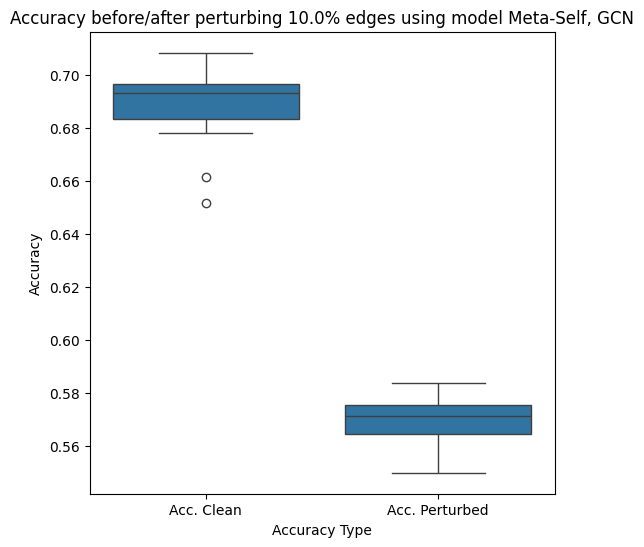

In [17]:
test_and_visualize(adj, modified_adj, test_gcn, "GCN")

=== testing GAT on original(clean) graph ===
=== testing GAT on attacked graph ===


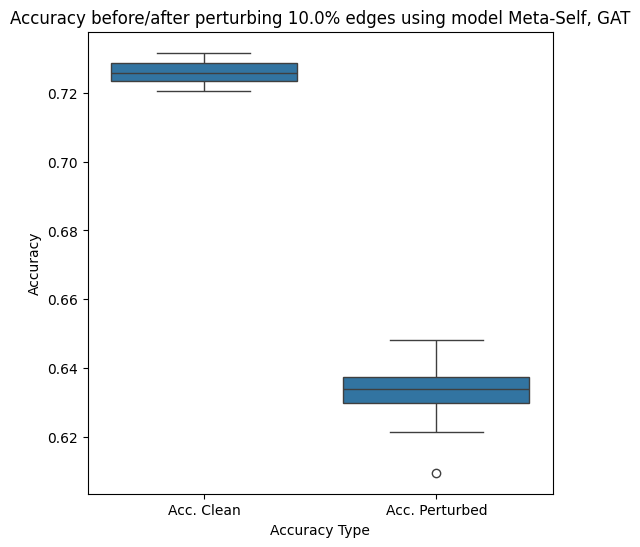

In [19]:
test_and_visualize(adj, modified_adj, test_gat, "GAT")

=== testing GATv2 on original(clean) graph ===
=== testing GATv2 on attacked graph ===


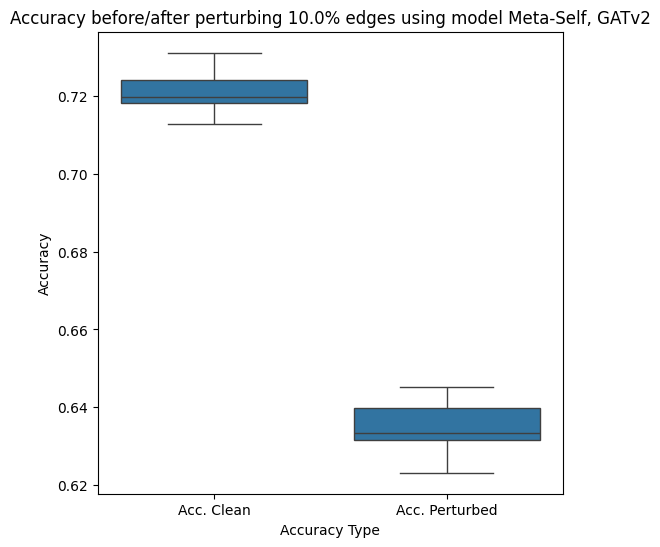

In [21]:
test_and_visualize(adj, modified_adj, test_gatv2, "GATv2")